In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/data.csv')

In [3]:
# Let's take a look at the first few rows...
print(df.head())

# and a summary of the data
print(df.info())

# check for any missingness
print(df.isnull().sum())

   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None
Age            0
SystolicBP 

In [4]:
#next let's convert "RiskLevel" to Numerical Values
risk_mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
df['RiskLevel'] = df['RiskLevel'].map(risk_mapping)

# make sure it looks okay
print(df['RiskLevel'].value_counts())


RiskLevel
0    406
1    336
2    272
Name: count, dtype: int64


In [5]:
#analyze duplicate values
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")



Number of duplicate rows: 562


That's quite a few duplicates, they could potentially skew or bias our model.  There may be a legitimate reason there are so many duplicates in the dataset, but let's drop them due to their potential to skew or bias for now.

In [6]:
#remove duplicates
df = df.drop_duplicates().reset_index(drop=True)
print("De-duplicated dataset stats", df.describe())

De-duplicated dataset stats               Age  SystolicBP  DiastolicBP          BS    BodyTemp  \
count  452.000000  452.000000   452.000000  452.000000  452.000000   
mean    29.194690  110.553097    75.418142    8.346173   98.692478   
std     13.767379   17.872282    13.754578    2.829209    1.410897   
min     10.000000   70.000000    49.000000    6.000000   98.000000   
25%     19.000000   90.000000    65.000000    6.900000   98.000000   
50%     25.000000  120.000000    80.000000    7.500000   98.000000   
75%     35.000000  120.000000    86.000000    7.900000   98.000000   
max     70.000000  160.000000   100.000000   19.000000  103.000000   

        HeartRate   RiskLevel  
count  452.000000  452.000000  
mean    73.949115    0.730088  
std      8.156973    0.833169  
min      7.000000    0.000000  
25%     70.000000    0.000000  
50%     76.000000    0.000000  
75%     80.000000    1.000000  
max     90.000000    2.000000  


In [7]:
#take a look at the descriptive statistics for the numerical values
print(df.describe())

              Age  SystolicBP  DiastolicBP          BS    BodyTemp  \
count  452.000000  452.000000   452.000000  452.000000  452.000000   
mean    29.194690  110.553097    75.418142    8.346173   98.692478   
std     13.767379   17.872282    13.754578    2.829209    1.410897   
min     10.000000   70.000000    49.000000    6.000000   98.000000   
25%     19.000000   90.000000    65.000000    6.900000   98.000000   
50%     25.000000  120.000000    80.000000    7.500000   98.000000   
75%     35.000000  120.000000    86.000000    7.900000   98.000000   
max     70.000000  160.000000   100.000000   19.000000  103.000000   

        HeartRate   RiskLevel  
count  452.000000  452.000000  
mean    73.949115    0.730088  
std      8.156973    0.833169  
min      7.000000    0.000000  
25%     70.000000    0.000000  
50%     76.000000    0.000000  
75%     80.000000    1.000000  
max     90.000000    2.000000  


Other than that, I'd say generally everything looks pretty good with a couple exceptions...
-I dont like a couple of the min values I see here
-There is a record with a minimum heart rate of 7.  I dont think that record is going to be helpful for us.  feels like either a mistake or an outlier.  I'd hope the systems would catch someone with a slowing heart rate before it got to 7.  Might be useful to exclude that, I'm going to leave it in for the time being and recommend further investigation to see if that is correct or useful.
-Also, I dont like that there is a 10 year old in the age ranks.  I would also recommend further analysis or tailoring to future data collection to a narrower band of age.  Some of the upper age limit seems untenable as well.  but it really depends on how the data was collected and what the reason for the visit was.  In other words, it's plausible that the purpose of the healthcare visit may have been to check if someone was pregnant or not.  In which case, the age range could make sense.  I'm just not sure, but will err on the side of leaving it in for now.

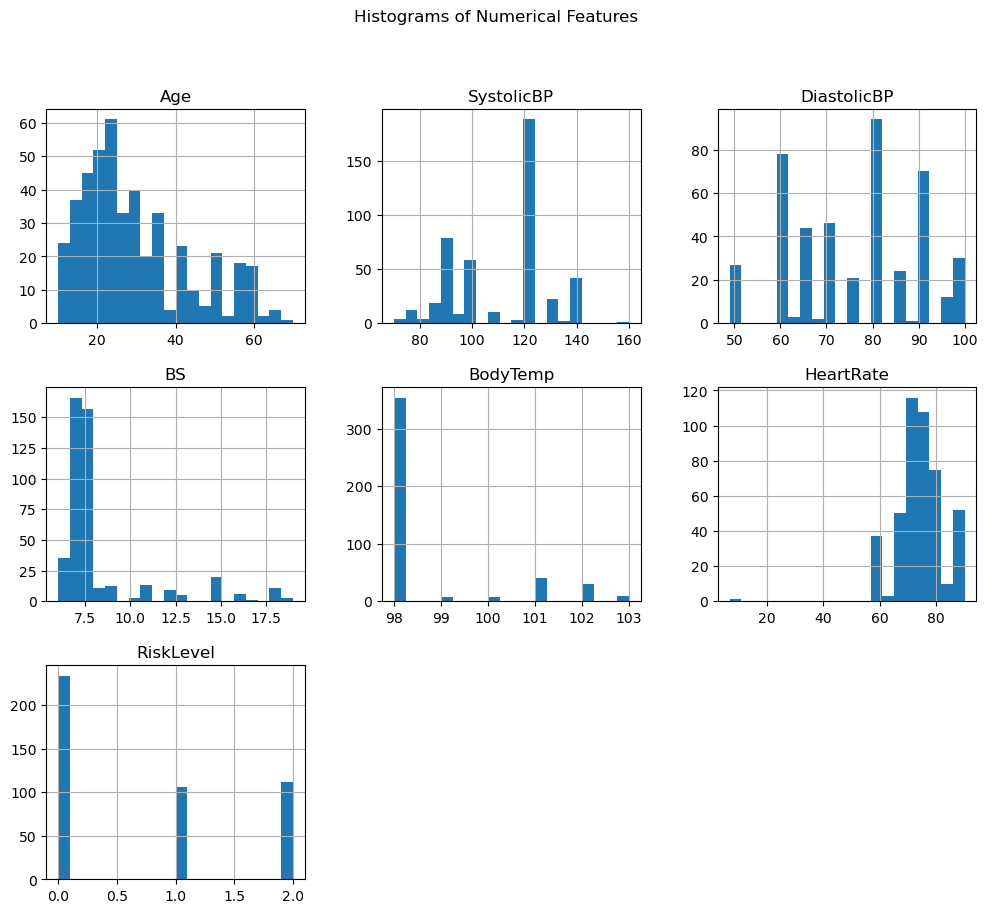

In [8]:
df.hist(figsize=(12, 10), bins=20)
plt.suptitle('Histograms of Numerical Features')
plt.show()

There are a couple interesting things here...
the distribution of age of the pregnant.  Looks like this may feature may be ripe for clustering perhaps a binary over/under 40.  Or something like 10-25, 25-40, 40+. Would be interesting to see the observations and the interactions with the other variables at each of those levels.

Also, for temperature, it appears there is large cluster around what is considered a 'normal' temperature and then above normal.  Might also be interesting to see the differences between these and the interactions with the other variables.

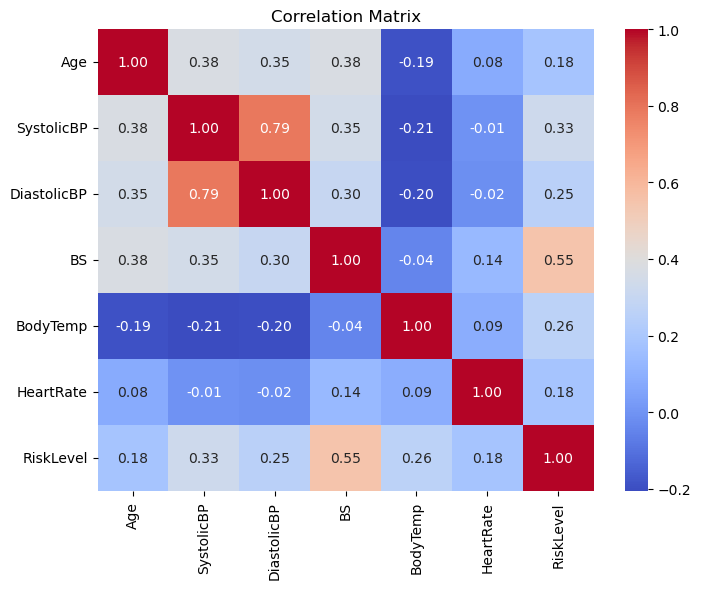

In [9]:
# that looks pretty good.
#now lets build the correlation matrix with a simple heatmap to observe the relationships between the features

corr = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

<Figure size 1200x800 with 0 Axes>

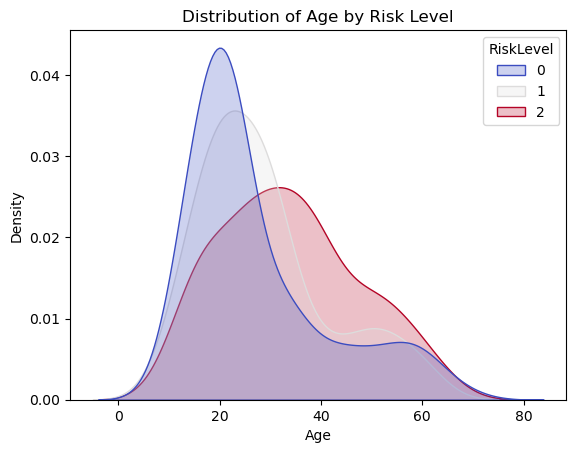

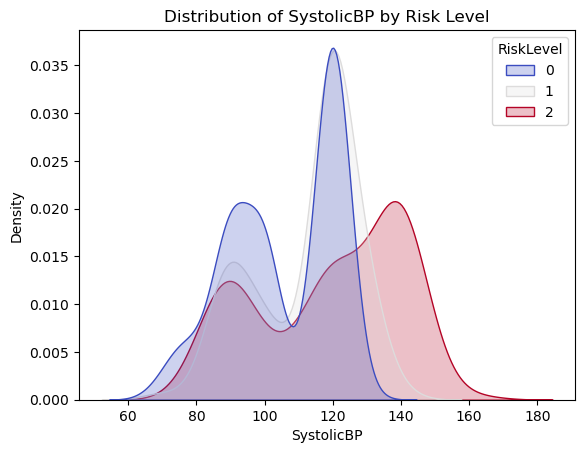

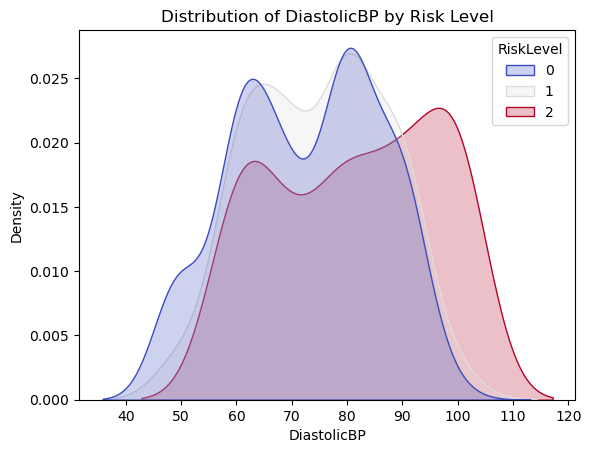

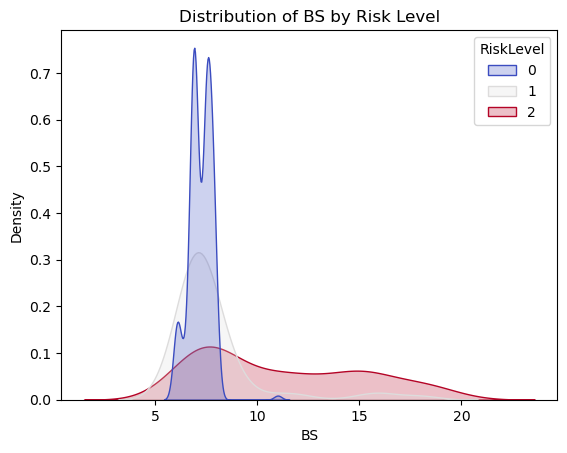

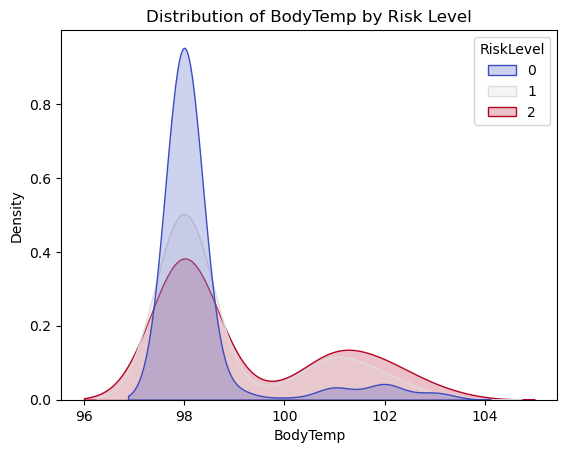

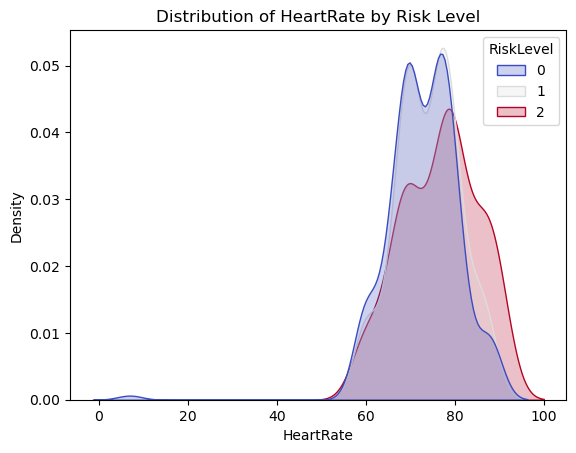

In [10]:
#let's take a looks at the some KDE (kernel density estimate) plots of the features across risk levels

features = df.columns[:-1]
plt.figure(figsize=(12, 8))

for feature in features:
    plt.figure()
    sns.kdeplot(data=df, x=feature, hue='RiskLevel', fill=True, common_norm=False, palette='coolwarm')
    plt.title(f'Distribution of {feature} by Risk Level')
    plt.show()

In [11]:
#take a look at the overall correlation values... I'm not convinced HeartRate is as informative as the other features..
print(df.corr()['RiskLevel'].sort_values(ascending=False))

RiskLevel      1.000000
BS             0.548888
SystolicBP     0.327365
BodyTemp       0.259701
DiastolicBP    0.254239
HeartRate      0.183289
Age            0.183010
Name: RiskLevel, dtype: float64


Here we get a decent sense of the key influencing factors:
-Blood pressure (both systolic and diastolic) and body temp show correlation with risk level
-Blood sugar has strong correlation with risk levels as well
-Heart rate may not be as important

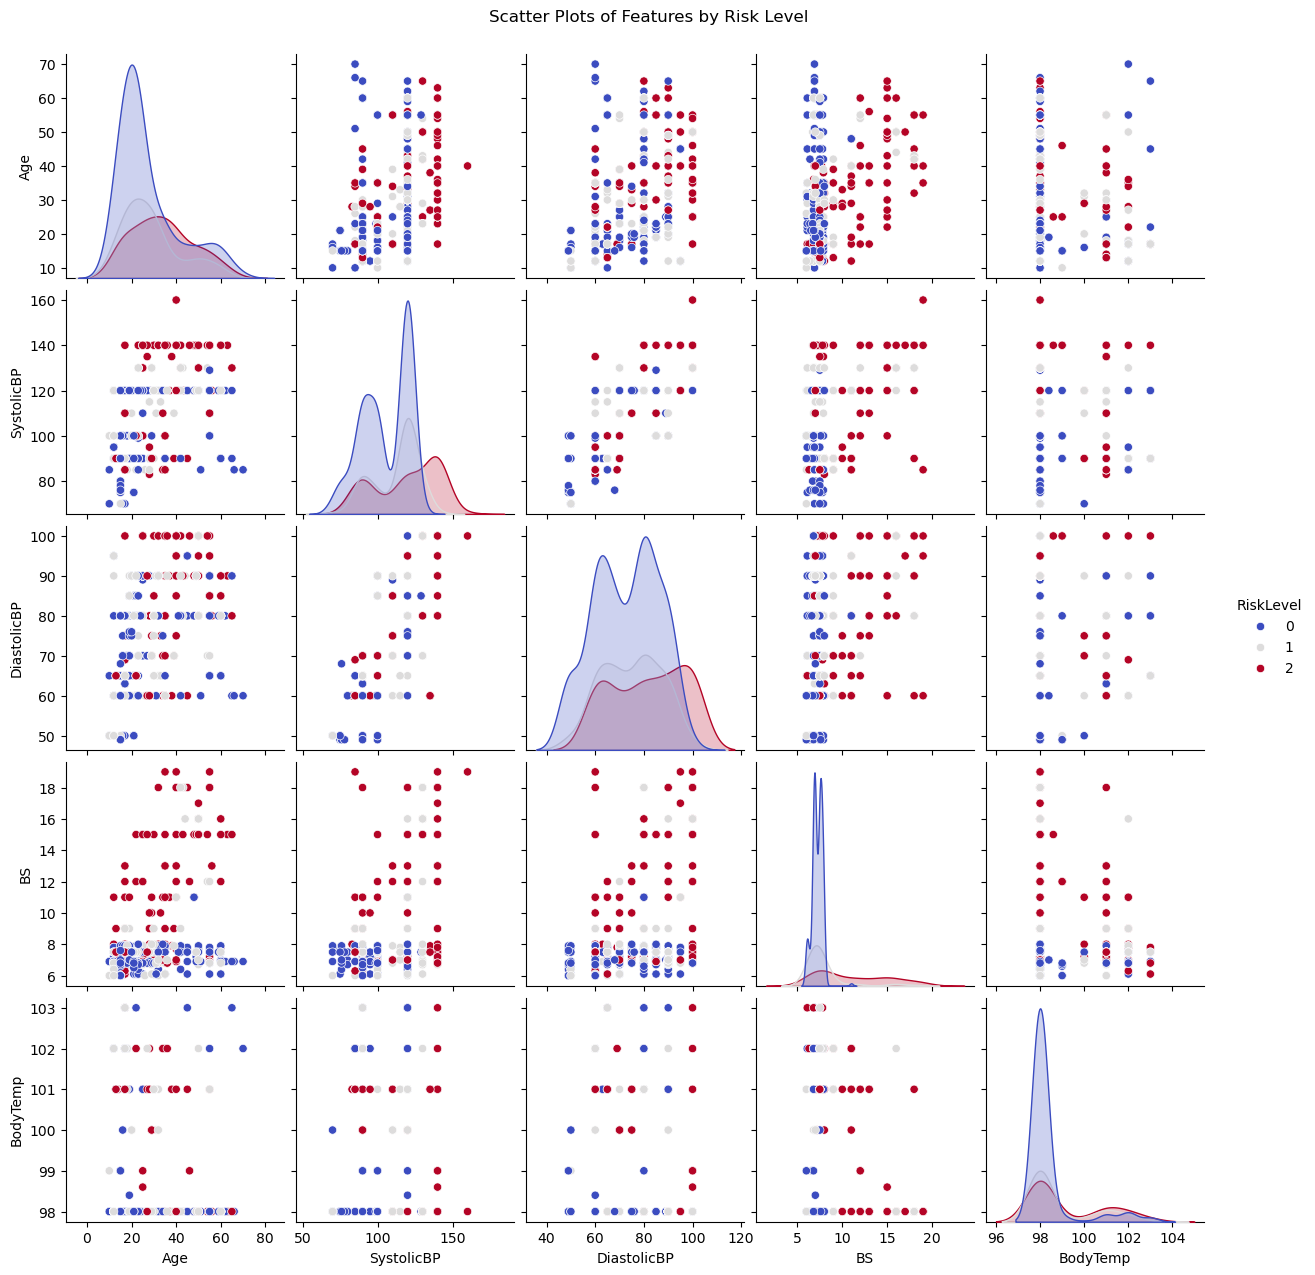

In [12]:
#let's take a look at some scatterplots to see if there is anything interesting there, or visible outliers...
# Scatter plots for selected features

sns.pairplot(df, vars=['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp'], hue='RiskLevel', palette='coolwarm')
plt.suptitle('Scatter Plots of Features by Risk Level', y=1.02)
plt.show()

RiskLevel
0    234
2    112
1    106
Name: count, dtype: int64


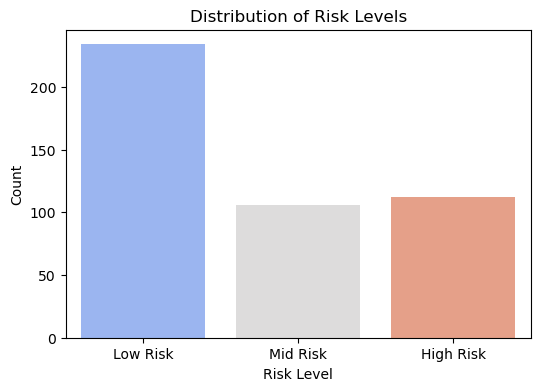

In [13]:
#let's also look at class imbalance.  we are going to start modeling with a basic logistic regression, so let's check the distribution of the RiskLevel
class_counts = df['RiskLevel'].value_counts()

print(class_counts)

# Plot the classes
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette = 'coolwarm')
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Low Risk', 'Mid Risk', 'High Risk'])
plt.show()

The classes appear to have some imbalance in the distribution of risk.  im not terribly moved that the classes should be rebalanced at this point. I think we will stick with what we have and perhaps address this in the modeling for the logistic regression or samping later on in the analysis

In [14]:
#for modeling we'll use a basic logistic regression, in later parts of the analysis we'll compare this to other models

# Split dataset into features (X) and target variable (y)
X = df.drop(columns=['RiskLevel'])
y = df['RiskLevel']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
#train the model
# Compute class weights to handle any imbalance in target variable
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the logistic regression model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight=class_weight_dict, max_iter=500)
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.64349376114082, 1: 1.415686274509804,
                                 2: 1.352059925093633},
                   max_iter=500, multi_class='multinomial')

In [16]:
# get the predictions
y_pred = log_reg.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy Score: {accuracy:.4f}")

#classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

Model Accuracy Score: 0.5934
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.66      0.72        47
           1       0.29      0.43      0.35        21
           2       0.67      0.61      0.64        23

    accuracy                           0.59        91
   macro avg       0.58      0.57      0.57        91
weighted avg       0.65      0.59      0.61        91



So the confusion matrix is used to evaluate the number of true positives, false positives, true negatives, and false negatives.  It may not be the best accuracy measure here, but it's important to take a look at the break out of where we predicted well and where we did not.  Let's take a look at the sheer accuracy score just to see what proportion of predictions we got correct in total...

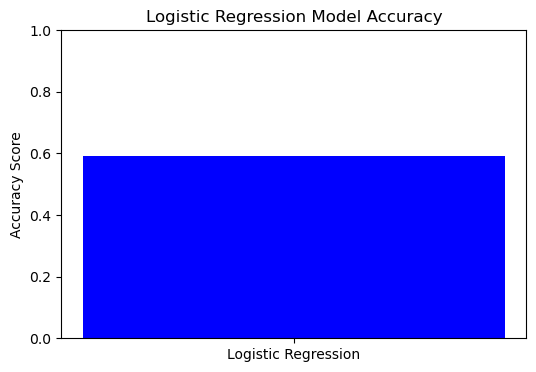

In [17]:
# Plot model accuracy
plt.figure(figsize=(6, 4))
plt.bar(["Logistic Regression"], [accuracy], color='blue')
plt.ylim(0, 1)
plt.ylabel("Accuracy Score")
plt.title("Logistic Regression Model Accuracy")
plt.show()

So here, accuracy is the measure of the proportion of correct predictions, but it may not be as useful for imbalanced datasets.

For purposes of evaluation let's look at ROC-AUC score.  It may be better for the imbalanced dataset and may be more easily compared to other models.  The ROC (receiver operator characteristic) will plot the true positive rate against the false positive rate while the AUC (area under the curve) will quantify how well the model differentiates between classes.  For AUC a score of 1 is considered perfect, a score of .5 would be considered a random guess, and anything less than .5 is useless because it's worse than a random guess.

We'll plot the curves for all classes of the target variable, because that might be interesting if the business case is to segment the population for different resaons, but for our model evaluations purposes we will focus on the total model score as this will be important and we will use it to compare to other models later on in the analysis.

In [18]:
# Create binaries for the target labels for ROC-AUC calculation and get probabilities
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  
y_pred_proba = log_reg.predict_proba(X_test)  

# Compute the ROC-AUC score using the OvR method (weighted averaged)
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr', average='weighted')
print(f"Multiclass ROC-AUC Score: {roc_auc:.4f}")

Multiclass ROC-AUC Score: 0.8018


So it looks like the overall logistic regression model has pretty good predictive ability.

Weighted Multiclass ROC-AUC Score: 0.8018


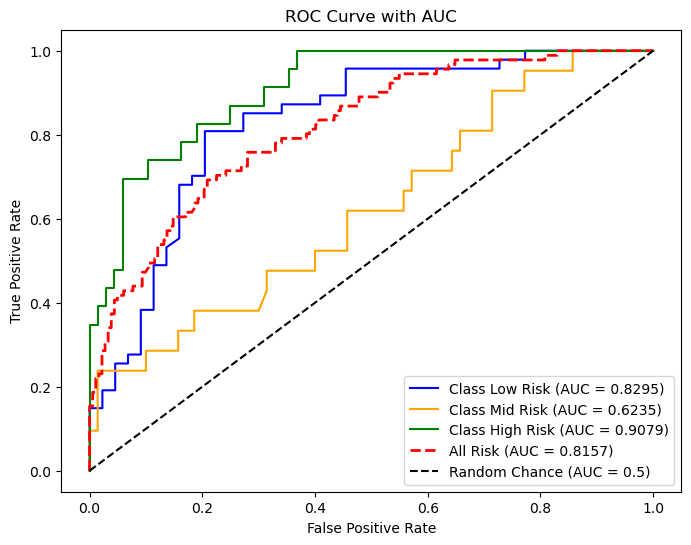

In [19]:
# Compute the weighted AUC score
roc_auc_weighted = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr', average='weighted')
print(f"Weighted Multiclass ROC-AUC Score: {roc_auc_weighted:.4f}")

# Define colors and labels for each class
colors = ['blue', 'orange', 'green']
labels = ['Low Risk', 'Mid Risk', 'High Risk']

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))

for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)  # Compute AUC for each class
    plt.plot(fpr, tpr, color=colors[i], label=f'Class {labels[i]} (AUC = {roc_auc:.4f})')

# Compute and plot the weighted-average ROC curve
fpr_weighted, tpr_weighted, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc_weighted_curve = auc(fpr_weighted, tpr_weighted)
plt.plot(fpr_weighted, tpr_weighted, color='red', linestyle='--', linewidth=2, label=f'All Risk (AUC = {roc_auc_weighted_curve:.4f})')

# Plot the diagonal (random chance line)
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance (AUC = 0.5)")

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with AUC')
plt.legend(loc='lower right')
plt.show()

I should note that the weighted Muliticlass ROC-AUC Score of .8018 differs slightly from that in the graph in that the roc curve treats the multi-class like a single-binary class, not weighing the class contributions explicitly based on frequency in the dataset.  but it is useful for purposes of overall visualization of the curve.  

next, let's take a look at deploying a more advanced model, Random Forest

In [20]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grid
rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

In [21]:
# Train Random Forest with GridSearch
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring='roc_auc_ovr', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

# Find Best model
rf_best = rf_grid.best_estimator_

# Predict probabilities
rf_proba = rf_best.predict_proba(X_test)

# ROC_AUC Score
rf_auc = roc_auc_score(y_test_binarized, rf_proba, multi_class='ovr', average='macro')

print(f"Random Forest ROC-AUC: {rf_auc:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest ROC-AUC: 0.7914


I was hopeful we'd get a better performing model, but it's slightly less robust based on the ROC-AUC.  Let's take a look at the confusion matrix to evaluate...

In [22]:
# Get predictions from the best Random Forest model
rf_pred = rf_best.predict(X_test)

# Compute the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, rf_pred)

#Print classification report
print("Classification Report for Random Forest Model:\n",classification_report(y_test, rf_pred))

Classification Report for Random Forest Model:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82        47
           1       0.36      0.19      0.25        21
           2       0.78      0.91      0.84        23

    accuracy                           0.73        91
   macro avg       0.64      0.66      0.64        91
weighted avg       0.68      0.73      0.69        91



Interestingly, this model performed better in Accuracy than the Logistic Regression (about 59% accurate in the logistic regression vs 73% here)
The Random Forest does a better job of predicting the low risk and the high risk, but struggles more than the logistic regression to classify the mid-risk.

Now let's take a look and see if we get a "boost" in model performance by XGBoost...

In [23]:
# Set up the XGB hyperparameter grid
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}


In [24]:
# Train XGBoost with GridSearch
xgb = XGBClassifier(objective="multi:softprob", eval_metric="mlogloss", use_label_encoder=False)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=cv, scoring='roc_auc_ovr', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

# Best model
xgb_best = xgb_grid.best_estimator_

# Predict probabilities
xgb_proba = xgb_best.predict_proba(X_test)

# Compute ROC-AUC
xgb_auc = roc_auc_score(y_test_binarized, xgb_proba, multi_class='ovr', average='macro')

print(f"XGBoost ROC-AUC: {xgb_auc:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
XGBoost ROC-AUC: 0.8047


Interesting, this is right about on par with our logistic regression model.  Let's take a look at the confusion matrix to see how that compares

In [25]:
xgb_pred = xgb_best.predict(X_test)

# Compute the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, xgb_pred)

# Print classification report
print("Classification Report for XGBoost Model:\n", classification_report(y_test, xgb_pred) )


Classification Report for XGBoost Model:
               precision    recall  f1-score   support

           0       0.75      0.98      0.85        47
           1       0.44      0.19      0.27        21
           2       0.81      0.74      0.77        23

    accuracy                           0.74        91
   macro avg       0.67      0.64      0.63        91
weighted avg       0.70      0.74      0.70        91



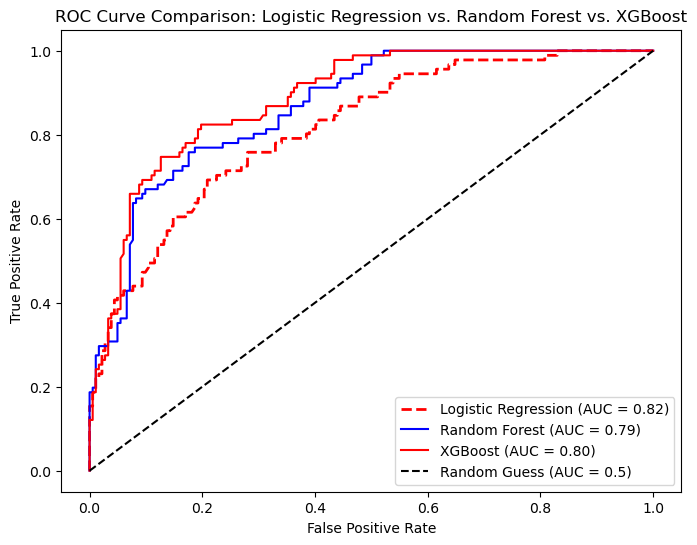

In [26]:
# Plot ROC Curves
plt.figure(figsize=(8, 6))

# Logistic Regression

fpr_weighted, tpr_weighted, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc_weighted_curve = auc(fpr_weighted, tpr_weighted)
plt.plot(fpr_weighted, tpr_weighted, color='red', linestyle='--', linewidth=2, label=f'Logistic Regression (AUC = {roc_auc_weighted_curve:.2f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test_binarized.ravel(), rf_proba.ravel())
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.2f})", color='blue')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_binarized.ravel(), xgb_proba.ravel())
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {xgb_auc:.2f})", color='red')

# Random classifier baseline
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.5)")

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Logistic Regression vs. Random Forest vs. XGBoost")
plt.legend(loc="lower right")
plt.show()

Overall, the models are a bit of a push in terms of the ROC curve in total.  I think the edge in terms of model deployment would go to XGBoost, based on the accuracy rate and better predictabliity of the low and high class risk class.